##1. Import libraries



*   Data cleaning libraries
*   Torch libraries for LSTM, tensor etc



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from collections import Counter
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns


#define device on which to run model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'cuda'

##2. Load in the data



*   Load in .tsv files
*   Concatenate files on reviews and conditions columns
*   Look for NAs - there are NAs so remove all rows with Nas





In [2]:
train_init = pd.read_csv('drugsComTrain_raw.tsv', sep = '\t')
test_init = pd.read_csv('drugsComTest_raw.tsv', sep = '\t')

#concantenate two data sets and save only the "reviews" and "conditions" columns
data = pd.concat([train_init,test_init])[['review','condition']]
data.head()


,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [3]:
#check for NAs in the dataset 
data.isnull().sum()

#remove all observations with NA in condition
data = data[pd.notnull(data['condition'])]
print("After NA removal:\n",data.isnull().sum())

After NA removal:
 review       0
condition    0
dtype: int64


##3. Exploratory Data Analysis



*   Print a review to evaluate what needs to be cleaned
*   Get counts of all conditions and make decision on where to cap it and make 
    a list of conditions
*   Make a plot for condition types vs frequency (histogram)









In [4]:
#there are many conditions in the dataset so obtain counts for each condition
cond_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)

#we will only consider the conditions that have more than 2500 reviews in the analysis
conditions = cond_df[cond_df['review']>2500]['condition'].values


<ipython-input-5-89bbff13dff0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['condition'] = data['condition'].replace(['Bipolar Disorde','Diabetes, Type 2'],['Bipolar Disorder','Type 2 Diabetes'])


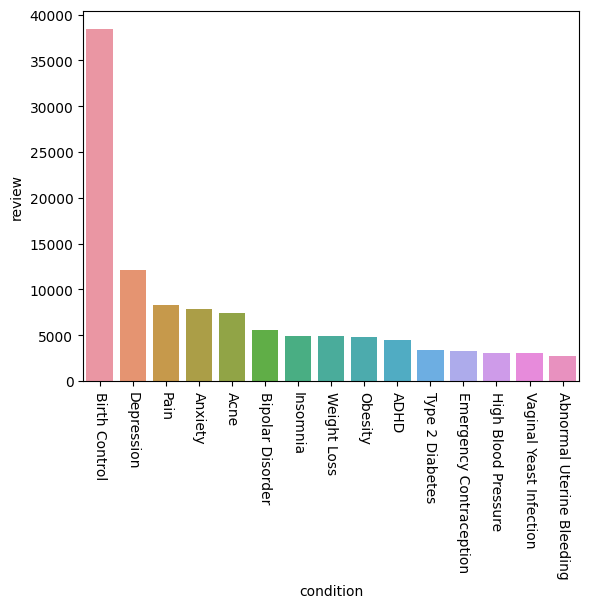

15


In [5]:
#remove all irrelevant conditions from the data
data['condition'] = data['condition'].apply(lambda x: x if x in conditions else '')
data = data[data['condition']!='']

#rename some of the mispelled conditions
data['condition'] = data['condition'].replace(['Bipolar Disorde','Diabetes, Type 2'],['Bipolar Disorder','Type 2 Diabetes'])
cond_df['condition'] = cond_df['condition'].replace(['Bipolar Disorde','Diabetes, Type 2'],['Bipolar Disorder','Type 2 Diabetes'])

#plot of conditions vs frequency
sns.barplot(x='condition',y='review',data=cond_df[cond_df['review']>2500])
plt.xticks(rotation=-90)
plt.show()

##4. Preprocess the data



*   Convert all words to lower case
*   Replace digits with no space  
*   Remove all punctuation
*   Remove stop words (separate function)
*   Lemmatization (separate function)
*   Other 



In [6]:
def clean_review(x):
  #make all text lowercase
  x = x.lower()
  #remove dashes
  x = re.sub('-', '', x)
  #remove punctuation, slashes
  x = re.sub(r'[^a-zA-z0-9\s]', ' ', x)
  #remove all numbers
  x = re.sub(r'\d', '', x)
  #remove excess whitespace
  x = re.sub(r'\s\s+', ' ', x)
  #remove weird quot word that appears
  x = re.sub(r'quot', '', x)
  #remove weird amp word that appears
  x = re.sub(r' amp ', '', x)
  return x

data['review'] = data['review'].apply(lambda x: clean_review(x))

#remove words that dont add meaning to sentence
def remove_stopwords(x):
  stop = stopwords.words('english')
  return " ".join(x for x in x.split() if x not in stop)

data['review'] = data['review'].apply(remove_stopwords)

#perform lemmatization on review words
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
def lemmatization(x):
  doc = nlp(x)
  return " ".join([token.lemma_ for token in doc])

data["review"] = data["review"].apply(lemmatization)


##5. Split into training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data['review'].values,data['condition'].values,stratify=data['condition'],test_size=0.25)

print("Train shape:\n", x_train.shape)
print("Test shape:\n", x_test.shape)

Train shape:
 (85731,)
Test shape:
 (28577,)


##6. Create dictionary and encode the words



*   Use most common words to create a dictionary
*   Encode using dictionary



In [8]:
#make a list of words from the training and testing set
x_train = list(x_train)

#form a dictionary of words
dict_list = []
for i in x_train:
  for j in i.split():
    dict_list.append(j)

#obtain the top 7000 most commonly used words
count_words = Counter(dict_list)
sort_words = sorted(count_words, key=count_words.get,reverse=True)[:7000]

#make onehot dictionary to convert common words into numerical format
onehot_dict = {w:i+1 for i,w in enumerate(sort_words)}
vocab_size = len(onehot_dict)

def word2int(dict_,word_list):
  conv_word_list = []
  for sentence in word_list:
    conv_word_list.append([dict_[word] for word in sentence.split() if word in dict_.keys()])
  return conv_word_list

#convert words in x_train and x_test into numerical representations
conv_x_train = word2int(onehot_dict, x_train)
conv_x_test = word2int(onehot_dict, x_test)

#encode the labels
le = LabelEncoder()
train_y = le.fit_transform(y_train)
test_y = le.transform(y_test)

##7. Pad each sentence



*   Find the mean review length
*   Pad sequence to mean review length



In [9]:
#find the mean review length and use as our maximum review length
rev_lens = [len(i) for i in conv_x_train]

table_dict = {"Review Len > 50":len([rev_lens for i in rev_lens if i > 50]),   
              "Review Len > 100":len([rev_lens for i in rev_lens if i > 100]),   
              "Review Len > 200":len([rev_lens for i in rev_lens if i > 200]),   
              "Review Len > 300":len([rev_lens for i in rev_lens if i > 300]),   
              "Review Len > 400":len([rev_lens for i in rev_lens if i > 400]),   
              "Review Len > 500":len([rev_lens for i in rev_lens if i > 500]),   
              "Review Len > 600":len([rev_lens for i in rev_lens if i > 600])}

#observe review lengths
review_lens = pd.DataFrame(table_dict.items(), columns = ['',''])
print(review_lens)

#upon further investigation, it appears that very few reviews are above 300, so this will be max_len
max_len = 300

#pad sequences: add 0s to make shorter review lengths equal to max_len or truncate longer reviews
train_x = pad_sequences(conv_x_train, maxlen=max_len)
test_x = pad_sequences(conv_x_test, maxlen=max_len)

                          
0   Review Len > 50  33229
1  Review Len > 100    138
2  Review Len > 200     23
3  Review Len > 300      3
4  Review Len > 400      2
5  Review Len > 500      2
6  Review Len > 600      0


##8. Batch and load as tensors



*   Make TensorDatasets
*   Make DataLoaders



In [10]:
#create tensor datasets
train_data = TensorDataset(torch.tensor(train_x),torch.tensor(train_y))
test_data = TensorDataset(torch.tensor(test_x),torch.tensor(test_y))

#create data loaders
batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [11]:
#verify that everything is working as expected
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 300])
Sample input: 
 tensor([[   0,    0,    0,  ..., 2859,  488,   19],
        [   0,    0,    0,  ...,   35, 4528,   12],
        [   0,    0,    0,  ..., 4336,  904, 2425],
        ...,
        [   0,    0,    0,  ..., 1413,  714,  218],
        [   0,    0,    0,  ...,  222,   45,   31],
        [   0,    0,    0,  ...,    1,   26, 2282]], dtype=torch.int32)
Sample label size:  torch.Size([100])
Sample label: 
 tensor([ 9, 10, 11,  5,  5,  4, 11, 12,  5,  0,  5,  6,  5,  5,  6,  5,  5,  5,
         5,  5,  5, 14, 14,  5,  6,  9,  0,  5, 14,  4,  5,  6, 11,  5,  6, 11,
        11,  4,  5,  6,  5,  8, 10,  4,  3,  7,  5,  5, 11,  5,  0,  1,  6,  5,
         6,  5, 14,  1, 12,  3,  5,  3,  5,  2,  6,  2,  5,  5,  5, 11,  5,  3,
        12,  5,  5,  4,  3,  6, 13,  3, 11, 12, 11,  6,  4,  1,  6, 11,  5,  1,
         5,  2,  5,  5,  5,  5,  5,  2, 12,  4])


##9. Define LSTM architecture



*   Define init
*   Define forward method
*   Define init_hidden



In [12]:
#define LSTM
class LSTM(nn.Module):
  def __init__(self, vocab_size, no_layers, embedding_size, hidden_size):
    super(LSTM, self).__init__()

    #define fields
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.no_layers = no_layers

    #define layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, num_layers=no_layers, hidden_size=self.hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.2)

    #forward method
  def forward(self, x, hidden):
    x = self.embedding(x)
    x = self.dropout(x)
    lstm_out, (ht, ct) = self.lstm(x)
    x = self.fc(ht[-1])
    return x

    #define initialization of hidden states
  def initHidden(self, batch_size):
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_size)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_size)).to(device)
    hidden = (h0,c0)
    return hidden

##10. Training



*   Train
*   Include info about train accuracy and loss
*   Make plots of accuracy and loss



In [13]:
#define hyperparameters
embedding_dim = 64
no_layers = 1
hidden_dim = 128
vocab_size = vocab_size + 1 #add the one to account for 0s for padding
output_size = len(le.classes_)
lr = 0.005
epochs = 15

In [14]:
#make model and move to GPU
model = LSTM(vocab_size, no_layers, embedding_dim, hidden_dim)
model = model.to(device)
print(model)

LSTM(
  (embedding): Embedding(7001, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=15, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:
#define loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
train_acc = []
train_loss = []
tot_epoch = []
torch.cuda.empty_cache()
#training loop
for epoch in range(epochs):
  correct = 0
  running_loss = 0
  #initialize hidden state
  hidden = model.initHidden(batch_size)
  for input, label in train_loader:
    input = input.to(device)
    label = label.to(device)
    #create new variables for hidden
    hidden = tuple([x.data for x in hidden])
    model.zero_grad()
    ypred = model(input, hidden)
    predicted = torch.argmax(ypred, 1)
    loss = loss_criterion(ypred, label)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    correct += (predicted == label).sum().item()
  accuracy = (100 * correct)/len(train_data)
  training_loss = running_loss/len(train_data)
  train_acc.append(accuracy)
  train_loss.append(training_loss)
  tot_epoch.append(epoch)
  print(f"Epoch: {epoch+1}, training acc: {accuracy:0.4f}, training loss: {training_loss:0.6f}")

Epoch: 1, training acc: 70.1240, training loss: 0.009133
Epoch: 2, training acc: 83.8961, training loss: 0.004561
Epoch: 3, training acc: 86.5008, training loss: 0.003834
Epoch: 4, training acc: 88.0137, training loss: 0.003359
Epoch: 5, training acc: 89.0880, training loss: 0.003039
Epoch: 6, training acc: 90.1133, training loss: 0.002783
Epoch: 7, training acc: 90.7175, training loss: 0.002572
Epoch: 8, training acc: 91.3952, training loss: 0.002394
Epoch: 9, training acc: 91.6845, training loss: 0.002323
Epoch: 10, training acc: 92.1417, training loss: 0.002201
Epoch: 11, training acc: 92.5721, training loss: 0.002076
Epoch: 12, training acc: 92.6538, training loss: 0.002051
Epoch: 13, training acc: 92.9232, training loss: 0.001995
Epoch: 14, training acc: 93.0923, training loss: 0.001953
Epoch: 15, training acc: 93.1238, training loss: 0.001923


Text(0.5, 1.0, 'Training Accuracy per Epoch')

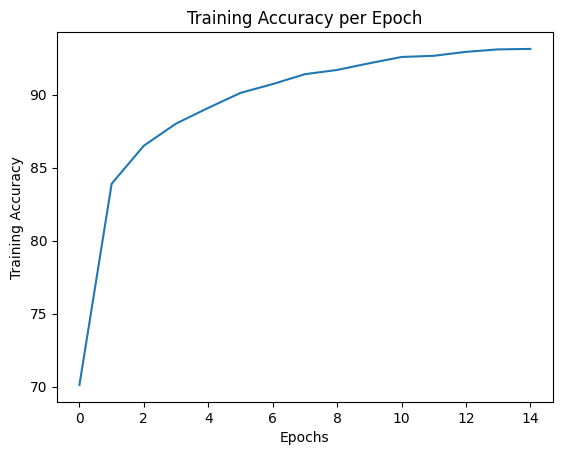

In [17]:
#plot the training accuracy
plt.plot(tot_epoch, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy per Epoch")

Text(0.5, 1.0, 'Training Loss per Epoch')

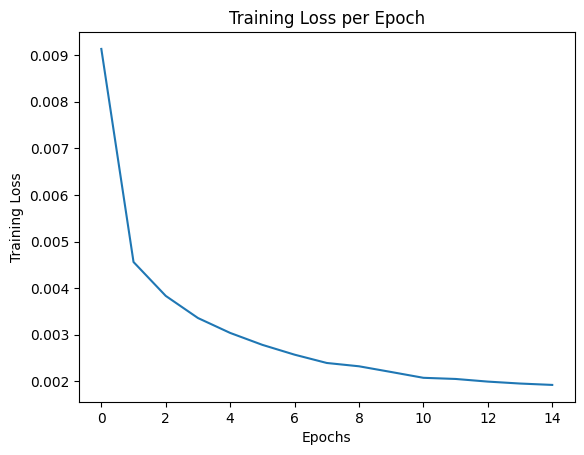

In [18]:
#plot the training loss
plt.plot(tot_epoch, train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")

##11. Evaluate accuracy on test data



*   Compute test accuracy
*   Make a confusion matrix



In [19]:
#evaluate model accuracy on testing data
correct = 0
total = len(test_data)
ypredicted = []
ytest = []
with torch.no_grad():
  hidden = model.initHidden(batch_size)
  for input, label in test_loader:
    input = input.to(device)
    label = label.to(device)
    hidden = tuple([x.data for x in hidden])
    ypred = model(input, hidden)
    predicted = (torch.argmax(ypred, 1)).data.cpu().numpy()
    ypredicted.extend(predicted)
    label = label.data.cpu().numpy()
    ytest.extend(label)
    
    for i in predicted:
      if (predicted[i] == label[i]):
        correct += 1

print("Testing Accuracy: ", round((100*correct)/total, 4))

Testing Accuracy:  87.3255


<Axes: >

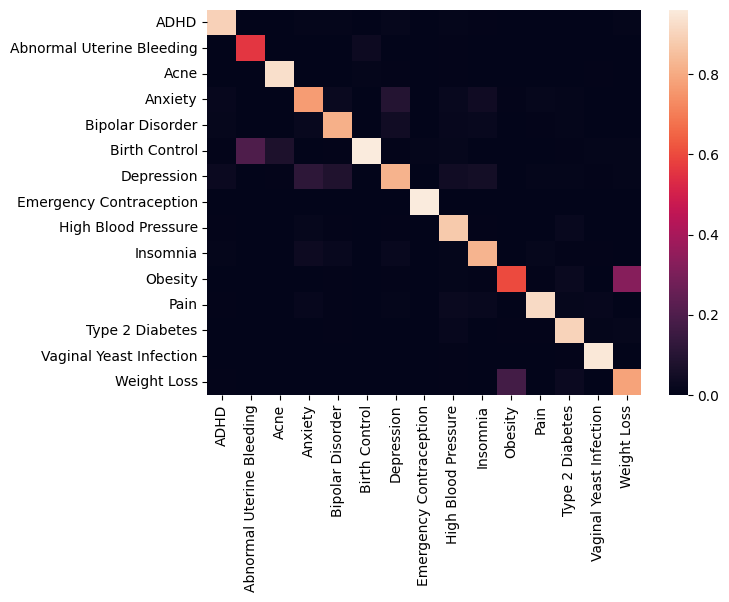

In [20]:
#make confusion matrix
cf_mat = confusion_matrix(ytest, ypredicted)
df = pd.DataFrame(cf_mat/np.sum(cf_mat, axis = 1), index = [i for i in le.classes_], columns = [i for i in le.classes_])
plt.figure(figsize = (7,5))
sns.heatmap(df)

##12. Inference



*   Predict classes for random reviews found on internet



In [21]:
#examples of reviews from the internet
adhd_text = 'Made college a possibility for me. I was able to focus and perform well in my classes. Before that I had been failing but knew I could do more than my grades were showing. Over the years (17 or so I believe) I have remained on the same dose with no side effects. I have since been promoted at work and although I am struggling to learn time management on a whole new level I suspect that is normal and not due to ADHD. I continue to take my medication to maintain'
bc_text = 'protected and unprotected, i haven’t gotten pregnant. june’s was my first birthcontrol (i’m still on it but thinking ab trying something else) and i’ve been on it for almost 2yrs now. at first it was the only medication i was taking at the time. my moods were content and my skin was pretty healthy w/ good complexion. now ik one of the biggest worries about birthcontrol is weight loss/gain.'
type2_text = 'Was prescribed 20 years ago for elevated blood sugars, now sugars are elevated and am diagnosed a diabetic. This medication doesnt appear to reduce my blood sugars significantly, have had better results with various supplements for more immediate reduction in blood sugar.'


def infer_condition(text):
  #clean text
  clean_text = clean_review(text)
  no_stop = remove_stopwords(clean_text)
  lemma_text = lemmatization(no_stop)

  #convert to tensor format
  sentence = []
  for word in lemma_text.split():
    if word in onehot_dict.keys():
      sentence.append(onehot_dict[word])

  tensor_text = torch.tensor(sentence)
  
  #predict class
  with torch.no_grad():
    hidden = model.initHidden(1)
    tensor_text = tensor_text.to(device)
    ypred = model(tensor_text, hidden)
    predicted = torch.argmax(ypred)
    predicted = predicted.data.cpu().numpy()
  
  #print results
  print(text)
  print(le.classes_[predicted])

#predict class for adhd review
infer_condition(adhd_text)

#predict class for birth control review
infer_condition(bc_text)

#predict class for type 2 diabetes review
infer_condition(type2_text)


Made college a possibility for me. I was able to focus and perform well in my classes. Before that I had been failing but knew I could do more than my grades were showing. Over the years (17 or so I believe) I have remained on the same dose with no side effects. I have since been promoted at work and although I am struggling to learn time management on a whole new level I suspect that is normal and not due to ADHD. I continue to take my medication to maintain
ADHD
protected and unprotected, i haven’t gotten pregnant. june’s was my first birthcontrol (i’m still on it but thinking ab trying something else) and i’ve been on it for almost 2yrs now. at first it was the only medication i was taking at the time. my moods were content and my skin was pretty healthy w/ good complexion. now ik one of the biggest worries about birthcontrol is weight loss/gain.
Birth Control
Was prescribed 20 years ago for elevated blood sugars, now sugars are elevated and am diagnosed a diabetic. This medication 